In [1]:
import numpy as np
import copy
import scipy.sparse as scp
from scipy.sparse import linalg

import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

# Riemannian Optimization

In [2]:
class Riemannian_Optimization:
    def __init__(self, A, tau, rank, maxiter, accuracy):
        self.tau = tau
        self.rank = rank
        self.maxiter = maxiter
        self.accuracy = accuracy
        
        self.A = A
        self.m = A.shape[0]
        self.n = A.shape[1]

        self.Omega = A.nonzero()

    def projection(self, Y1, Y2):
        rows = self.Omega[0]
        cols = self.Omega[1]
        
        nnz = rows.shape[0]
        data = np.zeros(rows.shape[0])
        
        for it in range(0, nnz):
            data[it] = np.dot(Y1[rows[it]].T, Y2[cols[it]])
        
        proj = scp.csr_matrix((data, (rows, cols)), shape=self.A.shape)
        
        return proj
    
    def grad(self, svd, Rw):
        U = svd[0]
        V = svd[2]
        Ru = Rw.T.dot(U)
        Rv = Rw.dot(V)
        
        M = np.dot(U.T, Rv)
        
        Up = Rv - np.dot(U, M)
        Vp = Ru - np.dot(V, M.T)
        
        grad_value = U.dot(M.dot(V.T)) + Up.dot(V.T) + U.dot(Vp.T)
        grad_list = [M, Up, Vp]
        grad = [grad_value, grad_list]
        
        return grad
    
    def create_Xw(self, X_svd):
        Y1 = np.dot(X_svd[0], X_svd[1])
        Y2 = X_svd[2]
        Xw = self.projection(Y1, Y2)
        return(Xw)
    
    def compute_initial_guess(self, X_new_svd, Rw, grad):
        """
        Compute the initial guess for line search t* = argmin_t f(X+t*eta)
        Args:
            X_new_svd (list): SVD in the new point in the form [U, S, V], X = USV.T
            Rw (np.array): Rw = Xw - Aw
            eta_new (list): conjugate vector in the new point in the form [value, [M, Up, Vp]]
        Returns:
            t (float)
        
        """
        R = -Rw
        U = X_new_svd[0]
        V = X_new_svd[2]
        M = grad[1][0]
        Up = grad[1][1]
        Vp = grad[1][2]
        
        Y1 = np.dot(U, M) + Up
        Y1 = np.hstack((Y1, U))
        Y2 = np.hstack((V, Vp))
        N = self.projection(Y1, Y2)
        top = N.T.dot(R)
        bottom = N.T.dot(N)
        t = top.diagonal().sum() / bottom.diagonal().sum()
        return t
    
    def compute_retraction(self, X_new_svd, tangent):

        k = self.rank
        M = tangent[0]
        Up = tangent[1]
        Vp = tangent[2]

        U  = X_new_svd[0]
        Sigma = X_new_svd[1]
        V  = X_new_svd[2]
        
        Zero = np.zeros((k, k))
        (Qu, Ru) = np.linalg.qr(Up)
        (Qv, Rv) = np.linalg.qr(Vp)
        top = np.hstack((Sigma + M, Rv.T))
        bottom = np.hstack((Ru, Zero))
        S = np.vstack((top, bottom))
        Us, Sigmas, Vs = np.linalg.svd(S)
        
        Vs = Vs.T
        Sigma_plus = np.diag(Sigmas[0:k] + 1e-16)
        
        Current = np.hstack((U, Qu))
        U_plus = np.dot(Current, Us[:, :k])

        Current = np.hstack((V, Qv))
        V_plus = np.dot(Current, Vs[:, :k])

        retraction = [U_plus, Sigma_plus, V_plus]
        return retraction
    
    def Initialization(self):

        m = self.m
        n = self.n
        k = self.rank
        
        diag = np.random.uniform(0, 1, k)
        diag = np.sort(diag)[::-1]
        
        S1 = np.diag(diag)
        U1 = np.random.uniform(0, 1, (m, k))
        V1 = np.random.uniform(0, 1, (n, k))
        
        Qu1, Ru1 = np.linalg.qr(U1)
        Qv1, Rv1 = np.linalg.qr(V1)
        X = [Qu1, S1, Qv1]
        
        Xw = self.create_Xw(X)
        R = Xw - self.A
            
        # Compute the gradient and direction
        xi = self.grad(X, R)
        eta = copy.deepcopy(xi)
            
        # Compute Retraction
        X_new = self.line_search(X, R, xi, eta)

        return(X, X_new, xi, eta)

    
    def vector_transport(self, X_old_svd, X_new_svd, v_list):
        """
        Calculate transport vector from previous tangent space to new tangent space
        
        Args:
            X_old_svd (list): SVD in the previous point in the form [U, S, V], X = USV.T
            X_new_svd (list): SVD in the new point in the form [U+, S+, V+], X+ = U+S+V+.T
            v_list (list): vector, we need to transport in the form [M, Up, Vp]

        Returns:
            np.array, list: Transport vector and corresponding matrices [value, [M+, Up+, Vp+]]
        """
        U = X_old_svd[0]
        S = X_old_svd[1]
        V = X_old_svd[2]
    
        U_plus = X_new_svd[0]
        S_plus = X_new_svd[1]
        V_plus = X_new_svd[2]
        
        M = v_list[0]
        Up = v_list[1]
        Vp = v_list[2]
        
        Av = np.dot(V.T, V_plus)
        Au = np.dot(U.T, U_plus)
        
        Bv = np.dot(Vp.T, V_plus)
        Bu = np.dot(Up.T, U_plus)
        
        M_plus_one = np.dot(Au.T, np.dot(M, Av))
        U_plus_one = np.dot(U, np.dot(M, Av))
        V_plus_one = np.dot(V, np.dot(M.T, Au))
        
        M_plus_two = np.dot(Bu.T, Av)
        U_plus_two = np.dot(Up, Av)
        V_plus_two = np.dot(V, Bu)
        
        M_plus_three = np.dot(Au.T, Bv)
        U_plus_three = np.dot(U, Bv)
        V_plus_three = np.dot(Vp, Au)
        
        M_plus = M_plus_one + M_plus_two + M_plus_three
        Up_plus = U_plus_one + U_plus_two + U_plus_three
        Up_plus = Up_plus - np.dot(U_plus, np.dot(U_plus.T, Up_plus))
        
        Vp_plus = V_plus_one + V_plus_two + V_plus_three
        Vp_plus = Vp_plus - np.dot(V_plus, np.dot(V_plus.T, Vp_plus))
        
        transport_value = np.dot(U_plus, np.dot(M_plus, V_plus.T)) + np.dot(Up_plus, V_plus.T) \
                                                        + np.dot(U_plus, Vp_plus.T)
        
        transport_list = [M_plus, Up_plus, Vp_plus]
        transport = [transport_value, transport_list]
        return transport
    
    
    def conjugate_direction(self, X_old_svd, X_new_svd, xi_old, xi_new, eta_old):
        """
        Compute the conjugate direction by PR+ in the new point
        
        Args:
            X_old_svd (list): SVD in the previous point in the form [U, S, V], X = USV.T
            X_new_svd (list): SVD in the new point in the form [U+, S+, V+], X+ = U+S+V+.T
            xi_old (list): tangent vector in the previous point in the form [value, [M, Up, Vp]]
            xi_new (list): tangent vector in the new point in the form [value, [M, Up, Vp]]
            eta_old (list): conjugate vector in the previous point in the form [value, [M, Up, Vp]]

        Returns:
            np.array, list: conjugate vector and corresponding list in the new point [M+, Up+, Vp+]
        """
        # Transport previous gradient and direction to current tangent space:
        xi_bar = self.vector_transport(X_old_svd, X_new_svd, xi_old[1])
        eta_bar = self.vector_transport(X_old_svd, X_new_svd, eta_old[1])
        
        # Compute conjugate direction
        delta = xi_new[0] - xi_bar[0]
        top = np.trace(np.dot(delta.T, xi_new[0]))
        
        # Пока с trace, переделать
        bottom = np.trace(np.dot(xi_old[0].T, xi_old[0]))
        betta = np.maximum(0, top/bottom)
        eta_value = -xi_new[0] + betta*eta_bar[0]
        
        # Renew eta_list
        M_eta_bar = eta_bar[1][0]
        Up_eta_bar = eta_bar[1][1]
        Vp_eta_bar = eta_bar[1][2]
        
        M_xi = xi_new[1][0]
        Up_xi = xi_new[1][1]
        Vp_xi = xi_new[1][2]
        

        M_eta = -M_xi + betta*M_eta_bar
        Up_eta = -Up_xi + betta*Up_eta_bar
        Vp_eta = -Vp_xi + betta*Vp_eta_bar
        
        eta_list = [M_eta, Up_eta, Vp_eta]
        eta = [eta_value, eta_list]
        
        # Compute angle between conjugate direction and gradient:
        top = np.trace(np.dot(eta[0].T, xi_new[0]))
        bottom = np.sqrt(np.trace(np.dot(eta[0].T, eta[0]))*np.trace(np.dot(xi_new[0].T, xi_new[0])))
        alpha = top/bottom
        
        # Reset to gradient if desired:
        if np.abs(alpha) <= 0.1:
            eta_value = xi_new[0].copy()
            eta_list = xi_new[1].copy()
            eta = [eta_value, eta_list]
        
        return eta
    
    
    def line_search(self, X, Rw, grad, con_grad):
        """
        Line search for finding m and t
        Args:
            
        Returns:
        """
        f_old = 0.5*(linalg.norm(Rw)**2)
        t = self.compute_initial_guess(X, Rw, con_grad)    

        m = 0        
        while True:
            step = (0.5**m)*t

            M_step = con_grad[1][0]*step
            Up_step = con_grad[1][1]*step
            Vp_step = con_grad[1][2]*step
            eta_step = [M_step, Up_step, Vp_step]
            
            X_new = self.compute_retraction(X, eta_step)
            f_new = 0.5*(linalg.norm(self.create_Xw(X_new) - self.A)**2)

            if (f_old - f_new >= -0.0001*step*np.trace(np.dot(grad[0].T, con_grad[0]))):
                break

            m = m + 1

        return X_new
    
    def create_matrix_from_svd(self):
        
        U = self.approx[0]
        S = self.approx[1]
        V = self.approx[2]
        X = U.dot(S.dot(V.T))
        self.solution = X
        pass
    
    def LRGeomCG(self):
        
        residuals = []
        X_old, X_new, xi_old, eta_old = self.Initialization()
        iters=0
        while True:
            if(iters > self.maxiter):
                break
            iters+=1
            #print('Num_of_iter ', iters)
            Xw = self.create_Xw(X_new)
            R = Xw - self.A
            xi_new = self.grad(X_new, R)
            
            if np.linalg.norm(xi_new[0]) <= self.tau:
                break
            
            # Compute a conjugate direction by PR+
            eta_new = self.conjugate_direction(X_old, X_new, xi_old, xi_new, eta_old)
            # Compute Retraction
            X_cur = self.line_search(X_new, R, xi_new, eta_new)
            
            # Renew X_old_svd and X_new_svd
            X_old = copy.deepcopy(X_new)
            X_new = copy.deepcopy(X_cur)
            
            # Renew xi_old and eta_new
            xi_old = copy.deepcopy(xi_new)
            eta_old = copy.deepcopy(eta_new)

            # Calculate residuals
            Xw = self.create_Xw(X_new)
            R = Xw - self.A
            cur_res = 0.5*(linalg.norm(R, ord='fro')**2)
            residuals.append(cur_res)
            if cur_res <= self.accuracy:
                break
       
        self.residuals = residuals
        self.approx = copy.deepcopy(X_new)
        self.create_matrix_from_svd()
        pass

# Soft Input

In [3]:
class SoftInput():
    def __init__(self, X):
        self.X = X
        self.nonzero = self.X.nonzero()
        
    def fit(self, lambdas, maxiter=np.inf, tol=1e-6, start_rank=100):
        self.rank = start_rank
        self.tol = tol
        self.lambdas = np.sort(lambdas)[::-1]
        self.Z_proj = sparse.csr_matrix(self.X.shape)
        self.S = np.zeros((self.rank,))
        self.U = np.zeros((self.X.shape[0], self.rank))
        self.Vt = np.zeros((self.rank, self.X.shape[1]))
        
        self.U_approx = []
        self.Vt_approx = []
        
        for l in self.lambdas:
            num_iter = 0
            while (num_iter < maxiter):
                self.update_Z_proj()
                
                lin_op = spla.LinearOperator(self.X.shape,
                                             matvec=self.matvec,
                                             rmatvec=self.rmatvec)
                U, S, Vt = spla.svds(lin_op, self.rank)
                
                S -= l
                S[S < 0] = 0
                
                if (num_iter > 0):
                    rel_err = np.linalg.norm(S - self.S) ** 2 / np.linalg.norm(self.S) ** 2
                else:
                    rel_err = 2 * self.tol
                
                S = S[S > 0]
                self.rank = S.shape[0]
                
                U = U[:, :self.rank]
                Vt = Vt[:self.rank, :]
                
                self.U = U
                self.Vt = Vt
                self.S = S
                
                self.Vt = np.diag(self.S).dot(self.Vt)
                
                if (rel_err < self.tol):
                    print('converged with %e' %(rel_err))
                    break
                
                num_iter += 1
                
            self.U_approx.append(self.U)
            self.Vt_approx.append(self.Vt)
        
        return self.lambdas, self.U_approx, self.Vt_approx
    
    def update_Z_proj(self):
        proj_data = np.empty(self.nonzero[0].size)
        for i in range(self.nonzero[0].size):
            proj_data[i] = self.U[self.nonzero[0][i], :].dot(self.Vt[:, self.nonzero[1][i]])
        self.Z_proj = sparse.csr_matrix((proj_data, self.nonzero), self.X.shape)
            

    def matvec(self, vec):
        res = self.X.dot(vec) - self.Z_proj.dot(vec)
        res += self.U.dot(self.Vt.dot(vec))
        return res
    
    def rmatvec(self, vec):
        res = self.X.T.dot(vec) - self.Z_proj.T.dot(vec)
        res += self.Vt.T.dot(self.U.T.dot(vec))
        return res


# ALS

In [4]:
class ALS(object):
    
    def __init__(self, k=10, lambda_ = 10, max_iter=10, tol=1e-5, missed_val = 0, print_iter=False):
        self._k = k
        self._lambda = lambda_
        self._max_iter = max_iter
        self._missed_val = missed_val
        self._tol = tol
        self._print_iter = print_iter
        self._errors = []
    
    def fit(self, ratings):
        self.A = ratings.copy()
        self.Omega = self.A.nonzero()
        
        residuals = []
        #initial assigning of factors X, Y
        X, Y = np.abs(np.random.rand(self._k, ratings.shape[0])), np.abs(np.random.rand(self._k, ratings.shape[1]))
        
        Xw = self.projection(X.T, Y.T)
        R = Xw - self.A
        cur_res = 0.5*(linalg.norm(R, ord='fro')**2)
        residuals.append(cur_res)
        
        for i in range(self._max_iter):
            column_diff_norm = 0
            if self._print_iter:
                print(i)

            #flag shows that X and Y changed much, so we should not stop
            flag = True

            for j in range(ratings.shape[0]):
                #take row in matrix of observations with which we will work
                row = ratings.getrow(j).toarray().ravel()

                #find arguments of elemnts in row which were not missed
                args = []
                if self._missed_val == 'NaN':
                    args = np.argwhere(~np.isnan(row)).T[0]
                else:
                    args = np.argwhere(row != self._missed_val).T[0]

                #create matrices to save temporary results
                summation_inv = np.zeros((self._k, self._k))
                summation = np.zeros((self._k, 1))

                #for every non-nan element in row we take corresponding column of Y and make manipulations
                for arg in args:
                    summation_inv = summation_inv + (Y[:, arg].reshape(-1,1)).dot(Y[:, arg].reshape(1, -1))
                    summation = summation + row[arg] * Y[:, arg].reshape(-1,1)

                #update the corresponding column of X
                new_X = solve(summation_inv + self._lambda * np.eye(self._k), summation)
                column_diff_norm += np.linalg.norm(X[:,j] - new_X) / np.linalg.norm(X[:,j])
                X[:,j] = new_X.reshape(-1,)

            #repeat everything for matrix Y
            for j in range(ratings.shape[1]):
                #take column in matrix of observations with which we will work
                column = ratings.getcol(j).toarray().ravel()

                #find arguments of elemnts in column which were not missed
                args = []
                if self._missed_val == 'NaN':
                    args = np.argwhere(~np.isnan(column)).T[0]
                else:
                    args = np.argwhere(column != self._missed_val).T[0]

                #create matrices to save temporary results
                summation_inv = np.zeros((self._k, self._k))
                summation = np.zeros((self._k, 1))

                #for every non-nan element in row we take corresponding column of Y and make manipulations
                for arg in args:
                    summation_inv = summation_inv + (X[:, arg].reshape(-1,1)).dot(X[:, arg].reshape(1, -1))
                    summation = summation + column[arg] * X[:, arg].reshape(-1,1)

                #update the corresponding column of Y
                new_Y = solve(summation_inv + self._lambda * np.eye(self._k), summation)
                column_diff_norm += np.linalg.norm(Y[:,j] - new_Y) / np.linalg.norm(Y[:,j])
                Y[:,j] = new_Y.reshape(-1)

            self._errors.append(column_diff_norm)
            
            Xw = self.projection(X.T, Y.T)
            R = Xw - self.A
            cur_res = 0.5*(linalg.norm(R, ord='fro')**2)
            residuals.append(cur_res)
            
            if column_diff_norm < 1e-5:
                break

        #save the results as the attribute of class
        self._X = X
        self._Y = Y
        self.residuals = residuals
        
    def get_factors(self):
        return self._X, self._Y
    
    def continue_fit(self, X, Y):
        pass
        
    def predict(self):
        return (self._X.T).dot(self._Y)
    
    def get_errors(self):
        return self._errors
    
    def projection(self, Y1, Y2):
        rows = self.Omega[0]
        cols = self.Omega[1]
        
        nnz = rows.shape[0]
        data = np.zeros(rows.shape[0])
        
        for it in range(0, nnz):
            data[it] = np.dot(Y1[rows[it]].T, Y2[cols[it]])
        
        proj = scp.csr_matrix((data, (rows, cols)), shape=self.A.shape)
        
        return proj

# Анализ

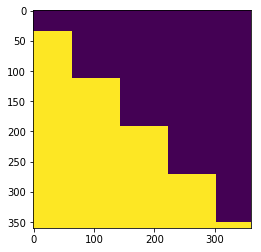

In [5]:
img = np.array(Image.open('test.png'), dtype=np.float64)[:, :, 0]
img[img == 0] = 100
img = img[:360, :360]
plt.imshow(img)
plt.show()

In [6]:
# random init
num = img.size // 10

np.random.seed(25)
row_ind = np.random.randint(0, img.shape[0], size=num)
col_ind = np.random.randint(0, img.shape[1], size=num)

row_ind = np.append(row_ind, np.arange(360))
col_ind = np.append(col_ind, np.arange(360))

X = scp.csr_matrix((img[(row_ind, col_ind)], (row_ind, col_ind)), shape=img.shape)

for i in range(1, 5):
    X[X == 100 * i] = 100
    X[X == 255 * i] = 255

In [7]:
X.shape

(360, 360)

# Riemannian solver

In [8]:
import numpy as np
import copy
import scipy.sparse as scp
from scipy.sparse import linalg

import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

In [9]:
riman = Riemannian_Optimization(X, tau=1e-16, rank=6, maxiter=500, accuracy = 1e-12)
riman.LRGeomCG()

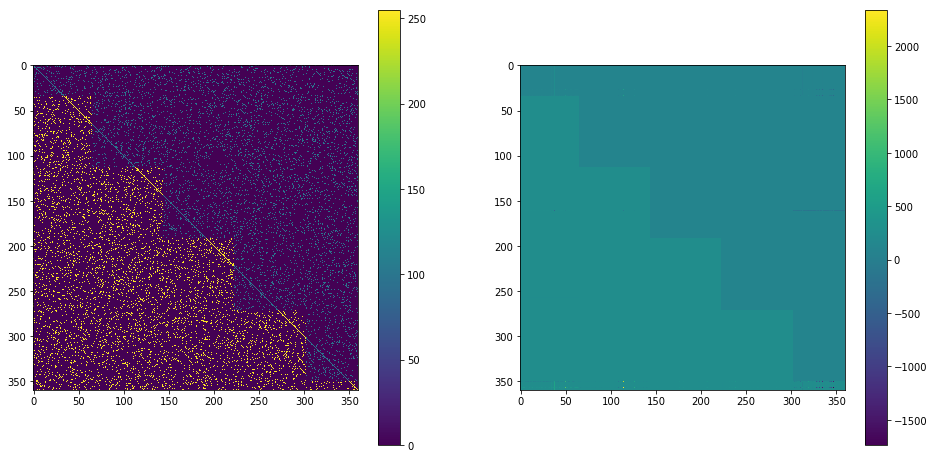

In [10]:
plt.figure(figsize=(16, 8))

plt.subplot(121)
plt.imshow(X.toarray())
plt.colorbar()

plt.subplot(122)
plt.imshow(riman.solution)
plt.colorbar()
plt.show()

In [11]:
Answ = riman.create_Xw(riman.approx)
linalg.norm(Answ-X)

0.82440927175836654

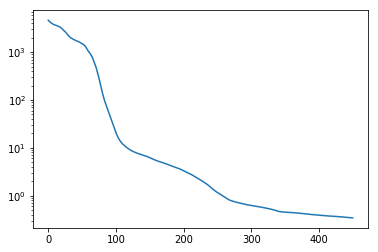

In [12]:
plt.plot(riman.residuals[50:])
plt.yscale('log')

# Soft Input

In [13]:
import numpy as np
import scipy.sparse.linalg as spla
import scipy.sparse as sparse

soft_input = SoftInput(X)

In [14]:
lambdas = np.linspace(0, 100, 10)
#print(lambdas)
lambdas, U_approximations, V_approximations = soft_input.fit(lambdas=lambdas, maxiter=50, start_rank=100, tol=1e-6)

converged with 9.851117e-07
converged with 3.528850e-07


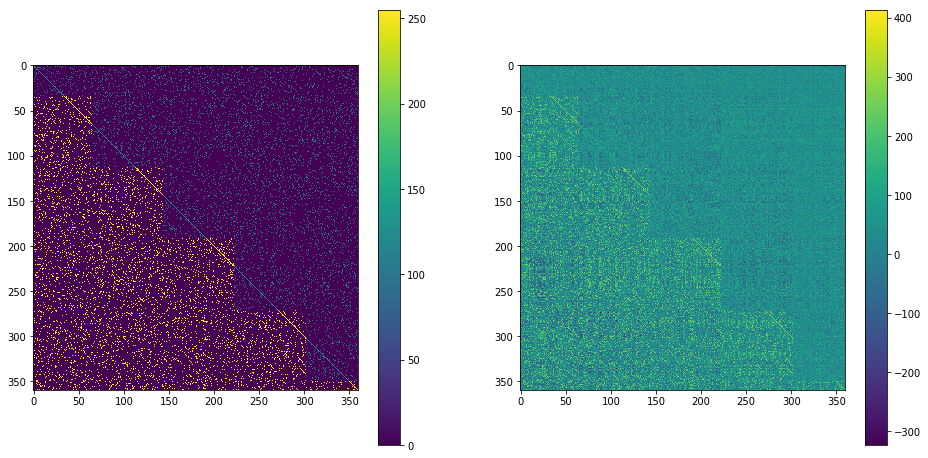

In [16]:
plt.figure(figsize=(16, 8))

plt.subplot(121)
plt.imshow(X.toarray())
plt.colorbar()

plt.subplot(122)
A = U_approximations[-1].dot(V_approximations[-1])
#A[A < 0] = 0 
plt.imshow(A)
plt.colorbar()
plt.show()

In [17]:
np.unique(X.toarray())

array([   0.,  100.,  255.])

# ALS

In [18]:
from scipy import sparse
from scipy.linalg import solve
import matplotlib.pyplot as plt
from PIL import Image
from copy import deepcopy
from itertools import product
import scipy.ndimage

In [19]:
als = ALS(k=100, lambda_= 0.1, max_iter=8, missed_val=0)

In [20]:
als.fit(X)

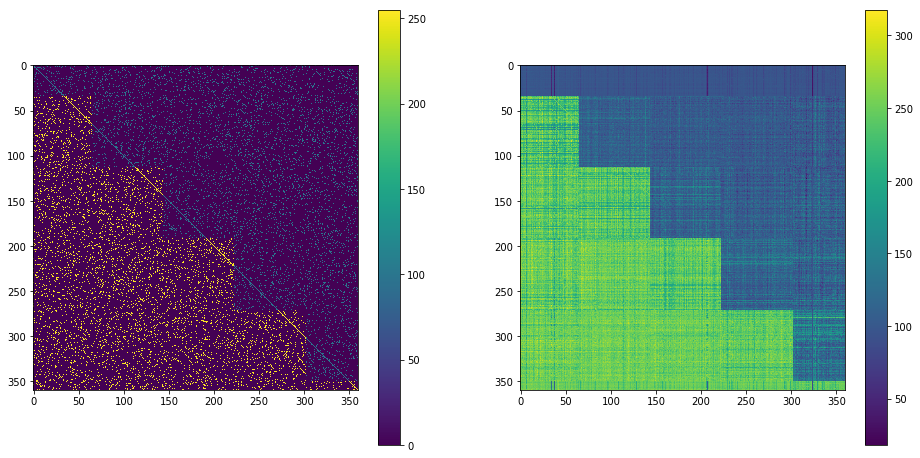

In [21]:
plt.figure(figsize=(16, 8))

plt.subplot(121)
plt.imshow(X.toarray())
plt.colorbar()

plt.subplot(122)
A = als.predict()
plt.imshow(A)
plt.colorbar()
plt.show()

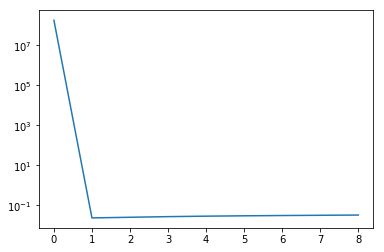

In [22]:
plt.plot(als.residuals)
plt.yscale('log')

In [23]:
0.5*(linalg.norm(als.A, ord='fro')**2)

228740224.99999997

# Skolkovo

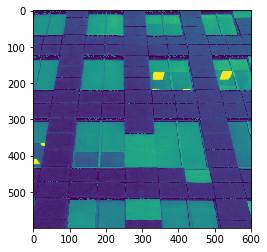

In [24]:
img = np.array(Image.open('sk.png'), dtype=np.float64)[:, :, 0]
img[img == 0] = 100
plt.imshow(img)
plt.show()

In [25]:
# random init
img = img[:599, :599]

num = img.size // 10

np.random.seed(25)
row_ind = np.random.randint(0, img.shape[0], size=num)
col_ind = np.random.randint(0, img.shape[1], size=num)

row_ind = np.append(row_ind, np.arange(599))
col_ind = np.append(col_ind, np.arange(599))

X = scp.csr_matrix((img[(row_ind, col_ind)], (row_ind, col_ind)), shape=img.shape)

for i in range(1, 5):
    X[X == 100 * i] = 100
    X[X == 255 * i] = 255
X.max()

759.0

In [26]:
img.shape

(599, 599)

In [27]:
als = ALS(k=100, lambda_= 0.1, max_iter=5, missed_val=0)
als.fit(X)

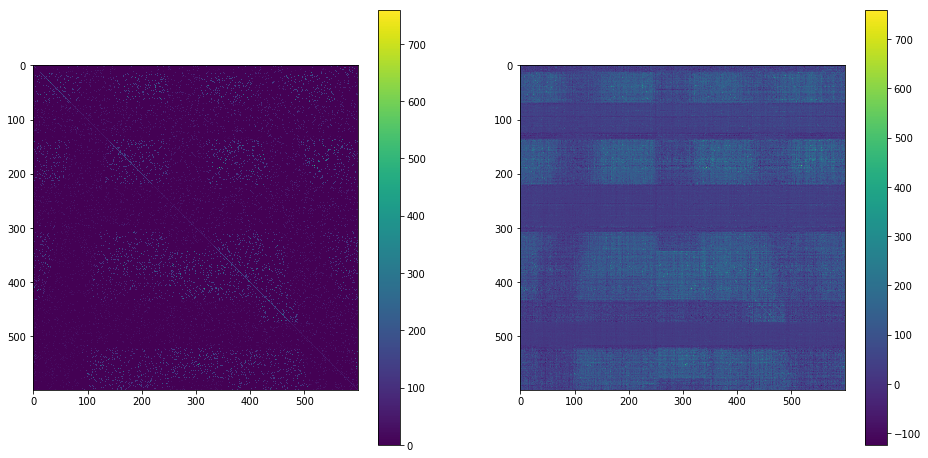

In [28]:
plt.figure(figsize=(16, 8))

plt.subplot(121)
plt.imshow(X.toarray())
plt.colorbar()

plt.subplot(122)
A = als.predict()
plt.imshow(A)
plt.colorbar()
plt.show()

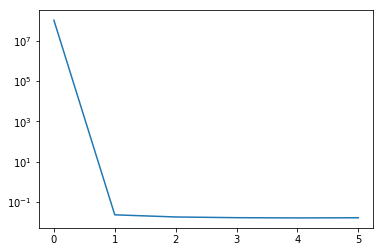

In [29]:
plt.plot(als.residuals)
plt.yscale('log')

In [30]:
als.residuals[1]

0.023518633080763005